## 3.2 Gridded Observations

When climate information is needed for an expanded spatial region, instead of a collection of individual points, it is necessary that we use gridded observations in our analysis. To be useful for downscaling, the spatial resolution of the gridded observations must be finer than that of the climate model data being downscaled. With gridded obs, we can do all of the same exploratory data analysis as we did with station data, but results will typically be plotted as maps instead of 1D curves.

**NB: It's important to remember that working with gridded data can require significantly more computational resources (storage, memory, and processor time) than data for a single location, especially for high temporal frequencies (daily or greater), fine spatial resolutions (finer than 1 degree), and large spatial domains. Keep this in mind when downloading gridded data.**

In this guidebook, we'll focus on the gridded observational products hosted on the [PAVICS THREDDS server](https://pavics.ouranos.ca/datasets.html#a), which can be accessed directly using the OPeNDAP capability of the Python package [xarray](https://docs.xarray.dev/en/stable/). ``xarray`` is built for working with arrays with named dimensions (such as "time" or "latitude") and is the workhorse for doing climate analysis in Python. It shares much of the same functionality as ``Pandas`` and ``numpy`` for doing calculations, and supports [parallelizing operations](https://docs.xarray.dev/en/stable/user-guide/dask.html) with [dask](https://docs.dask.org/en/stable/), which can significantly speed up calculations involving large datasets.

These observations are at daily frequency and include spatial coverage for Canada only - if you require coverage for other regions or sub-daily data, you may be able to find what you're looking for by searching the [NCAR Climate Data Guide](https://climatedataguide.ucar.edu/), or you may need to rely on reanalysis data (described in the next section).

The dataset we'll explore here is the NRCAN gridded observations, derived from station oberservations using the ANUSPLIN interpolation algorithm. The spatial resolution is 10 km$\times$10 km, and data is available from 1950-2017. More information on this dataset can be found in [this publication](https://journals.ametsoc.org/doi/pdf/10.1175/2011BAMS3132.1).

First, we will use the python module ``siphon`` to set up a connection to the PAVICS server, and then we'll load the data using ``xarray.open_dataset()``.

In [8]:
import numpy as np
import xarray as xr
from clisops.core import subset
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog

# this is the URL for PAVICS' THREDDS server which hosts gridded observations. You can
# enter this URL into a browser (but change the .xml to .html) to explore the data catalog
url_gridded_obs = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/gridded_obs/catalog.xml"

# Create Catalog object - this contains the info for the datasets in this directory
cat = TDSCatalog(url_gridded_obs)

for dataset in cat.datasets:
    print(dataset)

nrcan_v2.ncml
nrcan.ncml


In [2]:
# there are two versions of the NRCAN dataset. We will use the more recent one, version 2.
cds = cat.datasets[0] 

# open the dataset using the OPenDAP URL
nrcan_ds = xr.open_dataset(cds.access_urls["OPENDAP"])

# this will print out an interactive summary of the contents of the dataset
nrcan_ds

<xarray.Dataset>
Dimensions:  (lat: 510, lon: 1068, time: 24837)
Coordinates:
  * lat      (lat) float32 83.46 83.38 83.29 83.21 ... 41.29 41.21 41.12 41.04
  * lon      (lon) float32 -141.0 -140.9 -140.8 -140.7 ... -52.21 -52.13 -52.04
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2017-12-31
Data variables:
    tasmin   (time, lat, lon) float32 ...
    tasmax   (time, lat, lon) float32 ...
    pr       (time, lat, lon) float32 ...
Attributes: (12/15)
    Conventions:          CF-1.5
    title:                NRCAN ANUSPLIN daily gridded dataset : version 2
    history:              Fri Jan 25 14:11:15 2019 : Convert from original fo...
    institute_id:         NRCAN
    frequency:            day
    abstract:             Gridded daily observational dataset produced by Nat...
    ...                   ...
    dataset_id:           NRCAN_anusplin_daily_v2
    version:              2.0
    license_type:         permissive
    license:              https://open.canada.ca/en/open-government-licence-c...
    attribution:          The authors provide this data under the Environment...
    citation:             Natural Resources Canada ANUSPLIN interpolated hist...

Acessing the data with ``xr.open_dataset()`` has returned an ``xr.Dataset`` object, which itself contains three ``xr.DataArray``s that store each of the three variables: precipitation, and daily maximum and minimum temperature. Using the package [cartopy](https://scitools.org.uk/cartopy/docs/latest/), we can take a peek at the data for a particular day and plot it on a map.

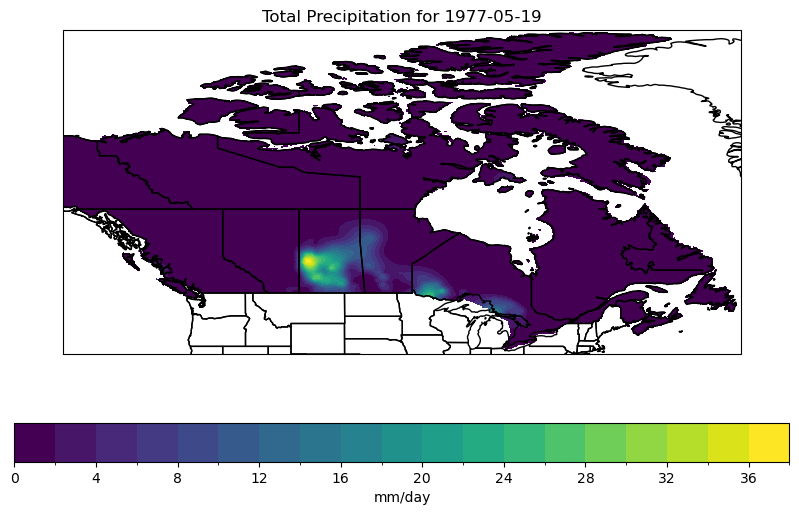

In [3]:
# set up axes with the 'PlateCarree' rectangular coordinate projection for plotting a map
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                         transform = ccrs.PlateCarree()),
                       figsize = (10, 6))

# select the precipitation data for a particular day - May 19 1977
sample_time = '1977-05-19'
precip_sample = nrcan_ds.pr.sel(time = sample_time) 

# units of the data are mm/s, but we prefer the standard unit of mm/day so let's convert units
# by multiplying by the number of seconds per day
precip_sample = precip_sample * 3600 * 24

# plot the data with 20 filled contours
precip_sample.plot.contourf(ax = ax, 
                            levels = 20, 
                            cbar_kwargs = {'label': 'mm/day', 'orientation': 'horizontal'}
                            )

# add coastlines to the map so we can easily determine what is land and what is not
# (although this dataset only includes data over land so it won't really make much of a difference)
ax.coastlines()

# add provincial borders and make sure they're plotted on top of the contour data
ax.add_feature(cfeature.STATES, zorder = 1)

# plot title
ax.set_title(f"Total Precipitation for {sample_time}")

plt.show()

This map shows that on the day in question, there was fairly heavy precipitation over western Saskatchewan, with some minor rainfall in parts of Ontario. Let's now take advantage of some of the powerful utilities of xarray to calculate 50-year return period values of precpitation for each grid cell in the dataset, to plot a map of the extreme precipitation for everywhere in a particular region.

In [12]:
# subset
lat_bnds = [42, 44]
lon_bnds = [-81, -79]

ds_region = subset.subset_bbox(nrcan_ds, lon_bnds = lon_bnds, lat_bnds = lat_bnds)

# get the precip data for all times
precip = ds_region.pr * 3600 * 24

# annual maxima
#precip_annmax = precip_region.groupby('time.year').max('time')

# replace nans with zeros, because scipy doesn't like nan's
#precip_annmax = xr.where(np.isnan(precip_annmax), 0, precip_annmax)

